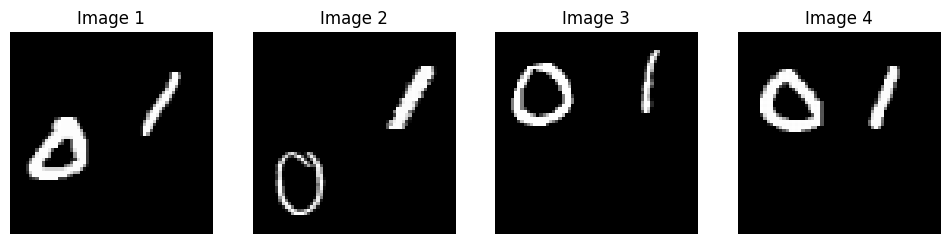

In [3]:
import os
import random
import matplotlib.pyplot as plt
from matplotlib.image import imread
root_directory = './double_mnist'
def display_images_from_folder(folder_path, num_images=4):
    image_files = os.listdir(folder_path)
    random_images = random.sample(image_files, num_images)
    
    plt.figure(figsize=(12, 6))
    for i, image_file in enumerate(random_images):
        image_path = os.path.join(folder_path, image_file)
        image = imread(image_path)
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f"Image {i + 1}")
        plt.axis('off')
    plt.show()
train_folder = os.path.join(root_directory, 'train', '01') 
display_images_from_folder(train_folder)


# MLP On MNIST

# CNN on MNIST

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


['00', '01', '04', '05', '06', '08', '09', '11', '12', '13', '14', '15', '16', '18', '19', '20', '21', '23', '24', '26', '28', '29', '30', '31', '33', '35', '37', '38', '41', '42', '43', '44', '45', '50', '51', '53', '54', '56', '59', '60', '62', '63', '65', '69', '70', '72', '74', '75', '76', '77', '79', '81', '82', '84', '85', '87', '88', '89', '90', '91', '94', '95', '97', '98']
Dataset CustomImageFolder
    Number of datapoints: 64000
    Root location: double_mnist/train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               Resize(size=(28, 28), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
['03', '07', '10', '22', '27', '34', '39', '40', '48', '52', '58', '61', '64', '71', '93', '99']
tensor([82, 89, 29, 37, 20, 82, 79, 89, 63, 62, 21, 85, 69, 33, 41, 42,  8, 63,
        94, 79, 90, 97, 18, 87, 50, 41, 65, 60,  5, 21, 11, 87, 88, 43,

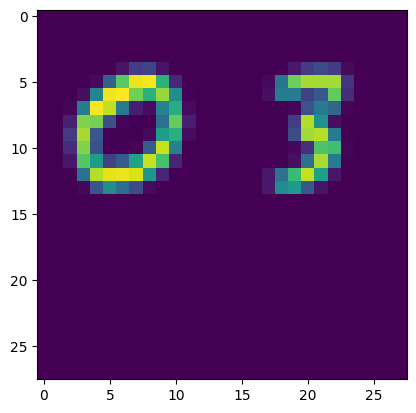

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import numpy as np
import os
from torchvision.datasets import ImageFolder

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_data_path = 'double_mnist/train'
val_data_path = 'double_mnist/val'
test_data_path = 'double_mnist/test'
class CustomImageFolder(ImageFolder):
    def __init__(self, root, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
    
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        folder_name = os.path.basename(os.path.dirname(path))
        return sample, int(folder_name) 
    
train_dataset = CustomImageFolder(train_data_path, transform=transform)
val_dataset = CustomImageFolder(val_data_path, transform=transform)
test_dataset = CustomImageFolder(test_data_path, transform=transform)
print(train_dataset.classes)
class_to_label = {str(i).zfill(2): i for i in range(100)}
# Define batch sizes
batch_size = 64
print(train_dataset)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
num_classes = 10
class_names = train_dataset.classes
class_names = val_dataset.classes
print(class_names)
for images, labels in train_loader:
    print(labels)
    break
for images, labels in val_loader:
    plt.imshow(images[0].permute(1, 2, 0))
    print(labels[0])
    print(labels)
    break

In [2]:
# Define a CNN class similar to the provided one
class MultiMNIST_CNN(nn.Module):
    def __init__(self, input_channels , num_classes , dropout_size=0.25, strides=2, kernel_size=3, pool_size=2):
        super(MultiMNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=kernel_size, padding=int((kernel_size-1)/2))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=pool_size, stride=strides)
        self.var1 = int((28-pool_size)/strides)+1
        self.dim = int((self.var1-pool_size)/strides)+1
        self.fc1 = nn.Linear(64 * self.dim * self.dim, 128)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_size)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * self.dim * self.dim)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = MultiMNIST_CNN(input_channels=1,num_classes=num_classes)
learning_rate = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [3]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            labels_group = labels//10
            optimizer.zero_grad()
            image = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            outputs = model(image)
            loss = criterion(outputs, labels_group)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group[k]==predicted[k]):
                    correct_train = correct_train+1

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        count = 0
        with torch.no_grad():
            for images, labels in val_loader:
                labels_group = labels // 10
                image = images.clone()
                left_half = images[:, :, :, :images.shape[3] // 2]
                image[:, :, :, (image.shape[3] // 2):] = left_half
                outputs = model(image)
                loss = criterion(outputs, labels_group)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels_group).sum().item()
                count = count+1

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels_group = labels // 10
            image = images.clone()
            left_half = images[:, :, :, :images.shape[3] // 2]
            image[:, :, :, (image.shape[3] // 2):] = left_half
            outputs = model(image)
            loss = criterion(outputs, labels_group)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels_group).sum().item()
            count = count+1
        test_accuracy = 100 * correct_test / total_test
        average_test_loss = (test_loss / len(test_loader))

    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


In [4]:
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
test_model(model,test_loader=test_loader,criterion=criterion)

Epoch 1/5, Train Loss: 0.6324, Train Acc: 79.24%, Val Loss: 0.1849, Val Acc: 94.56%
Epoch 2/5, Train Loss: 0.1911, Train Acc: 94.17%, Val Loss: 0.1305, Val Acc: 96.01%
Epoch 3/5, Train Loss: 0.1343, Train Acc: 95.89%, Val Loss: 0.1013, Val Acc: 96.78%
Epoch 4/5, Train Loss: 0.1089, Train Acc: 96.62%, Val Loss: 0.0868, Val Acc: 97.27%
Epoch 5/5, Train Loss: 0.0888, Train Acc: 97.20%, Val Loss: 0.0881, Val Acc: 97.39%
Test Loss: 0.0942, Test Acc: 97.16%


In [5]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3):
    train_losses, val_losses = [], []
    train_acc, val_acc = [] , []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            labels_group = labels % 10
            optimizer.zero_grad()
            image = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image[:, :, :, :(image.shape[3] // 2)] = right_half
            outputs = model(image)
            loss = criterion(outputs, labels_group)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            for k in range(labels.size(0)):
                if(labels_group[k]==predicted[k]):
                    correct_train = correct_train+1

        train_accuracy = 100 * correct_train / total_train
        train_losses.append(running_loss / len(train_loader))
        train_acc.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        count = 0
        with torch.no_grad():
            for images, labels in val_loader:
                labels_group = labels % 10
                image = images.clone()
                right_half = images[:, :, :, images.shape[3] // 2:]
                image[:, :, :, :(image.shape[3] // 2)] = right_half
                outputs = model(image)
                loss = criterion(outputs, labels_group)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels_group).sum().item()
                count = count+1

            val_accuracy = 100 * correct_val / total_val
            val_losses.append(val_loss / len(val_loader))
            val_acc.append(val_accuracy)

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracy:.2f}%')

    return train_losses, val_losses, train_acc, val_acc


def test_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    count = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels_group = labels % 10
            image = images.clone()
            right_half = images[:, :, :, images.shape[3] // 2:]
            image[:, :, :, :(image.shape[3] // 2)] = right_half
            outputs = model(image)
            loss = criterion(outputs, labels_group)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels_group).sum().item()
            count = count+1
        test_accuracy = 100 * correct_test / total_test
        average_test_loss = (test_loss / len(test_loader))

    print(f'Test Loss: {average_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')


In [9]:
train_losses, val_losses, train_acc, val_acc = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
test_model(model,test_loader=test_loader,criterion=criterion)

Epoch 1/3, Train Loss: 0.0722, Train Acc: 97.70%, Val Loss: 0.0788, Val Acc: 97.54%
Epoch 2/3, Train Loss: 0.0607, Train Acc: 98.04%, Val Loss: 0.0635, Val Acc: 98.18%
Epoch 3/3, Train Loss: 0.0524, Train Acc: 98.30%, Val Loss: 0.0762, Val Acc: 97.80%
Test Loss: 0.0763, Test Acc: 97.75%


# Permuted MNIST

In [ ]:
# To load the dataset, you can use np.load
import numpy as np
data = np.load("permuted_mnist.npz")
permuted_x_train = data["train_images"]
y_train = data["train_labels"]
permuted_x_test = data["test_images"]
y_test = data["test_labels"]

# CNN On Permuted MNIST